In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from torch_autoneb import suggest, config, find_minimum, neb, to_simple_graph, visualise
import torch
from torch import optim
import main
import pickle
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import yaml
import random
%matplotlib inline

In [138]:
# Replace this path with your own project directory
project_directory = "tmp/project_copy/"
assert os.path.isdir(project_directory), "Project directory was not found!"

In [139]:
# Load config
on_device = False
config_file = os.path.join(project_directory, "config.yaml")
model, minima_count, min_config, lex_config = main.read_config_file(config_file, on_device)
print(f"Model has {model.number_of_dimensions} dimensions.")

Files already downloaded and verified
Files already downloaded and verified
Model has 274042 dimensions.


In [126]:
model.model

DataModel(
  (model): CompareModel(
    (model): DenseNet(
      (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dense1): Sequential(
        (0): Bottleneck(
          (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): Bottleneck(
          (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
       

In [141]:
# Load graph
with open(os.path.join(project_directory, "graph.p"), "rb") as file:
    graph = pickle.load(file)
len(graph.nodes), len(graph.edges)

EOFError: Ran out of input

In [140]:
simple_graph = to_simple_graph(graph, lex_config.weight_key)#, lex_config.auto_neb_config.cycle_count)
len(simple_graph.edges)

3

## Connectivity Graph

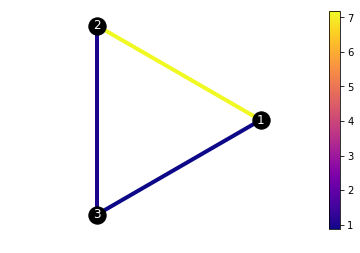

In [135]:
visualise.draw_connectivity_graph(simple_graph, lex_config.value_key, lex_config.weight_key)

## Minimum Spanning Tree

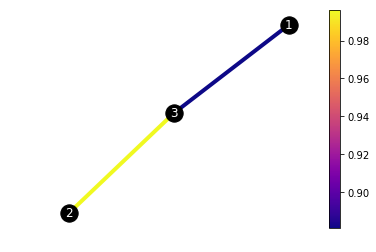

In [137]:
mst = nx.minimum_spanning_tree(simple_graph, lex_config.weight_key)
visualise.draw_connectivity_graph(mst, lex_config.value_key, lex_config.weight_key, nx.spring_layout(mst))

## Evaluation

In [ ]:
node_values = torch.Tensor([mst.nodes[node][lex_config.value_key] for node in mst.nodes])
saddle_values = torch.Tensor([mst.get_edge_data(*edge)[lex_config.weight_key] for edge in mst.edges])

print("Averages over minimum spanning tree:")
print(f"Minima:  {node_values.mean().item():.4f} ± {node_values.std().item():.4f} ({lex_config.value_key})")
print(f"Saddles: {saddle_values.mean().item():.4f} ± {saddle_values.std().item():.4f} ({lex_config.weight_key})")

## Loss along MST paths

In [ ]:
for edge in mst.edges:
    data = mst.get_edge_data(*edge)[lex_config.weight_key.replace("saddle", "dense")]
    lengths = mst.get_edge_data(*edge)["lengths"]
    visualise.plot_dense(data, lengths, True)
plt.ylabel(lex_config.weight_key.replace("saddle_", "").replace("_", " ").title())
plt.xticks([0, 1], ["$\\theta_1$", "$\\theta_2$"])
plt.xlim(-0.05, 1.05)